In [1]:
# Import all the required modules
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import math
from collections import OrderedDict
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch_lr_finder import LRFinder
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from resnet import ResNet18

In [2]:
from torchmetrics import Accuracy
from torchvision.datasets import CIFAR10 
import torch
from pytorch_lightning import LightningModule, Trainer
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchmetrics import Accuracy
from torchvision import transforms
import matplotlib.pyplot as plt
import random

PATH_DATASETS = os.environ.get("PATH_DATASETS", ".")
BATCH_SIZE = 256 


In [3]:
from torch.utils.data import Dataset
import numpy as np
class CIFAR10Dataset(Dataset):
    def __init__(self, data_dir, train=True, transform=None):
        self.data = CIFAR10(data_dir, train=train, download=True, transform=None)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, label = self.data[idx]
        if self.transform:
            # Apply the transformation in the correct format
            image = self.transform(image=np.array(image))['image']
        return image, label


In [4]:


class LitCIFAR(LightningModule):
    def __init__(self, data_dir=PATH_DATASETS, hidden_size=16, learning_rate=2e-4):

        super().__init__()

        # Set our init args as class attributes
        self.data_dir = data_dir
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate

        # Hardcode some dataset specific attributes
        self.num_classes = 10

        self.misclassified_indices = []

        # Define PyTorch model
        self.model = ResNet18()

        self.accuracy = Accuracy(num_classes=self.num_classes, task='multiclass')

    def forward(self, x):
        x = self.model(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=1)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.accuracy(preds, y)
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", self.accuracy, prog_bar=True)
        return loss

    # def test_step(self, batch, batch_idx):
    #     # Here we just reuse the validation_step for testing
    #     return self.validation_step(batch, batch_idx)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer


    

In [5]:
transform = A.Compose(
    [
        A.RandomCrop(height=32, width=32, p=0.2),
        A.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
        A.HorizontalFlip(),
        A.CoarseDropout(max_holes=1, max_height=16, max_width=16, min_holes=1, min_height=1, min_width=1, fill_value=[0.49139968*255, 0.48215827*255 ,0.44653124*255], mask_fill_value=None),
        ToTensorV2(),
    ]
)
test_transform = A.Compose(
    [
        A.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
        ToTensorV2(),
    ]
)

cifar_full = CIFAR10Dataset(PATH_DATASETS, train=True, transform=transform)
cifar_test = CIFAR10Dataset(PATH_DATASETS, train=False, transform=test_transform)
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


In [6]:

from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
# Setup a TensorBoard logger
train_loader = DataLoader(cifar_full, batch_size=512, num_workers=os.cpu_count())
test_loader = DataLoader(cifar_test, batch_size=512, num_workers=os.cpu_count())

logger = TensorBoardLogger("tb_logs", name="my_model")

trainer = Trainer(
    logger=logger,
    max_epochs=20,
)

model = LitCIFAR()
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders = test_loader)
torch.save(model.state_dict(), "/raid/users/mohammadibrahim-st/TSAI/S13/models/model.ckpt")


Trainer will use only 1 of 5 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=5)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('Graphics Device') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
2024-05-04 23:35:10.546812: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following i

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


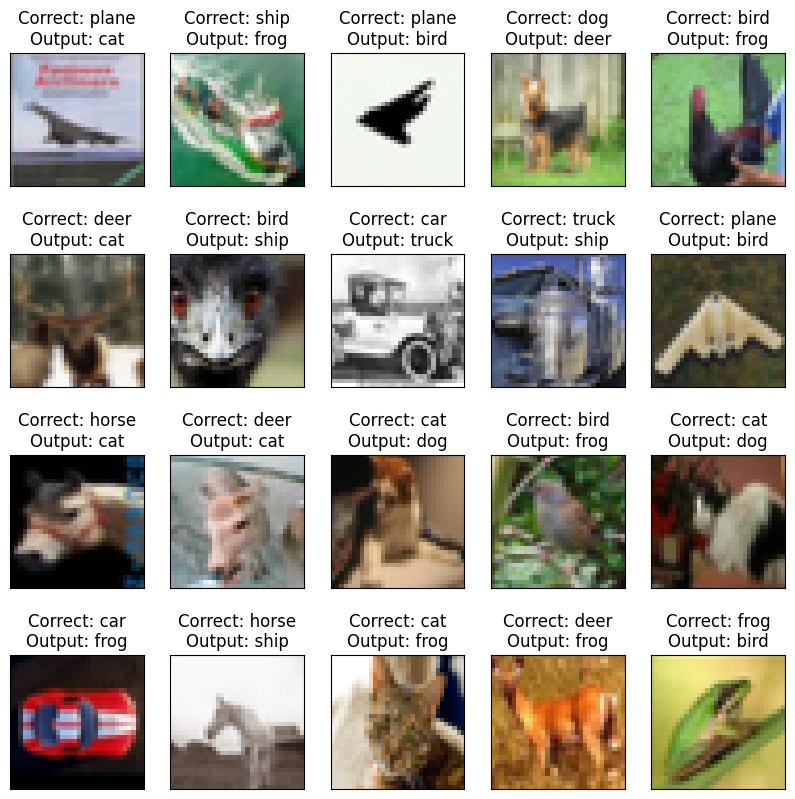

In [7]:
from utils import get_misclassified_data
from visualize import display_cifar_misclassified_data

# Denormalize the data using test mean and std deviation
inv_normalize = transforms.Normalize(
    mean=[-1.9899, -1.9844, -1.7111],
    std=[4.0486, 4.1152, 3.8314]
)

# Get the misclassified data from test dataset
model = model.to("cuda")
misclassified_data = get_misclassified_data(model, "cuda", test_loader)

# Plot the misclassified data
display_cifar_misclassified_data(misclassified_data, classes, inv_normalize, number_of_samples=20)